# 0. HST Analysis

1. Identify Beads (the young stellar superclusters) from the NUV (HST F390w) image
2. Plot Distirbution of galaxies in SDSS 1531
3. Histogram of Known redshifts
4. Relative velocity of central galaxies to cluster mean
5. Gas Stripped From Interactions with other gas-rich galaxies?


In [4]:
#set path to beads

path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [5]:
#system
from __future__ import division
import sys
import os
import glob

#numpy
import numpy as np
import scipy
import pandas as pd

#astropy
from astropy.io import ascii
from astropy.io import fits
from astropy.table import QTable
from astropy import wcs
from astropy.wcs import WCS
from astropy.modeling import models
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from astropy.coordinates import Galactic
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization.wcsaxes import Quadrangle
from astropy.coordinates import SkyCoord

#spectral fitting
import pyspeckit

import h5py

#PIL
from PIL import Image

#matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.style as style
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Ellipse, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set1_4 as brewermap


#gifs
import imageio 

#pv stuff
from pvextractor import extract_pv_slice
from pvextractor import Path
from spectral_cube import SpectralCube
#import aplpy
from PyAstronomy import pyasl

#seaborn
import seaborn as sns

#pv stuff
from pvextractor import extract_pv_slice
from pvextractor import Path
from spectral_cube import SpectralCube
#import aplpy
from astropy.coordinates import SkyCoord
from PyAstronomy import pyasl
import pyregion
from pvextractor import PathFromCenter
from regions import Regions


#smoothing
from scipy.ndimage.filters import gaussian_filter

import importlib

#astroquery
from astroquery.ned import Ned

# #warnings
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [7]:
#uncomment if need to reload module
importlib.reload(sf)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [8]:
#About my galaxy cluster
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

angular_diameter_distance = cosmo.angular_diameter_distance(z=zh) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=zh).to(u.kpc / u.arcsec)

In [9]:
#load hst data
f390_hdr, f390_wcs, f390_hdu =  sf.load_HST_data(path_to_beads, id_file=1)
f160_hdr, f160_wcs, f160_hdu =  sf.load_HST_data(path_to_beads, id_file=2)
f606_hdr, f606_wcs, f606_hdu =  sf.load_HST_data(path_to_beads, id_file=0)

In [10]:
fig_path = path_to_beads + 'Figures/paper/'

In [11]:
pf.styleplots()

### 1. Identify Beads

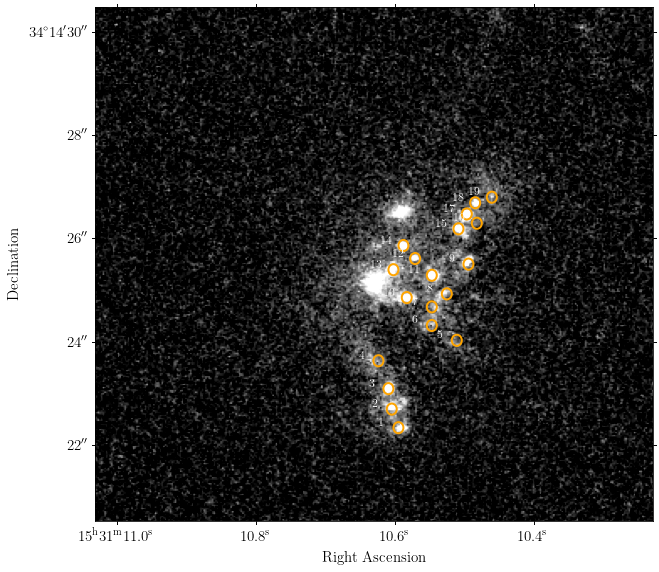

In [45]:
#plot NUV Image and cluster points on top
fig = plt.figure(figsize=(10, 10))
gs1 = GridSpec(1, 1)

hst_zoom = [ra+ 6e-4, dec, 5 * u.arcsec]

ax2 = fig.add_subplot(gs1[0], projection=WCS(f390_hdr))

ax2, cb2 = pf.ax_fits_map(f390_hdu, coords=hst_zoom, cmap=cm.Greys_r, ax=ax2, vmin=0, 
                    vmax=0.02, spitzer=True, cbar=False)


cluster_radec = [(ra + 4.5e-4, dec - 8.8e-4), (ra + 4.9e-4, dec - 7.8e-4), (ra + 5.1e-4, dec - 6.7e-4),
                (ra + 5.7e-4, dec - 5.2e-4), (ra + 1e-4, dec - 4.1e-4), (ra + 2.5e-4, dec - 3.3e-4), 
                (ra + 2.5e-4, dec - 2.3e-4), (ra + 1.6e-4, dec - 1.6e-4), (ra + 0.3e-4, dec), 
                (ra + 4e-4, dec - 1.8e-4), (ra + 2.5e-4, dec -0.6e-4 ), (ra + 3.5e-4, dec + 0.3e-4),
                (ra + 4.8e-4, dec - 3e-5), (ra + 4.2e-4, dec + 1e-4), (ra + 0.9e-4, dec + 1.9e-4),
                (ra - 0.2e-4, dec + 2.2e-4), (ra + 0.4e-4, dec + 2.7e-4), (ra - 0.1e-4, dec + 3.3e-4), 
                (ra - 1.1e-4, dec + 3.6e-4)]

for idc, coord in enumerate(cluster_radec):
    circle = plt.Circle((coord[0], coord[1]), 3e-5, edgecolor='orange', 
                            lw=2, facecolor='none', transform=ax2.get_transform('fk5')) 
    ax2.add_patch(circle)
    ax2.text(coord[0] + 1e-4, coord[1], '{}'.format(idc + 1), ha='center', 
                            va='bottom', fontsize=12, color='w', 
                            transform=ax2.get_transform('fk5')) 


In [46]:
table_path = path_to_beads + '/Analysis/tables/'
np.save(table_path + 'ysc_coords', cluster_radec)

### 2. Plot distribution of galaxies

In [47]:
#panstarrs
pstars_iband = path_to_beads + 'Analysis/panstarrs/panstarrs_iband_3000pixels.fits'
phdu, phdr, pwcs = pf.open_fits(pstars_iband)

In [14]:
#find all objects within virial radius in NED database
cluster_region = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='fk5')
result_table = Ned.query_region(cluster_region, radius=6 * u.arcmin, equinox='J2000').to_pandas()

In [15]:
#all galaxies in the field
sdss1531_field_galaxies = result_table.loc[np.where(result_table.Type == 'G')]

#galaxies with redshifts belonging to cluster
sdss1531_field_galaxies_z = sdss1531_field_galaxies.iloc[np.where((sdss1531_field_galaxies.Redshift > 0.3) & 
                                                                    (sdss1531_field_galaxies.Redshift < 0.4) )]

(3477.0, 6143.0)

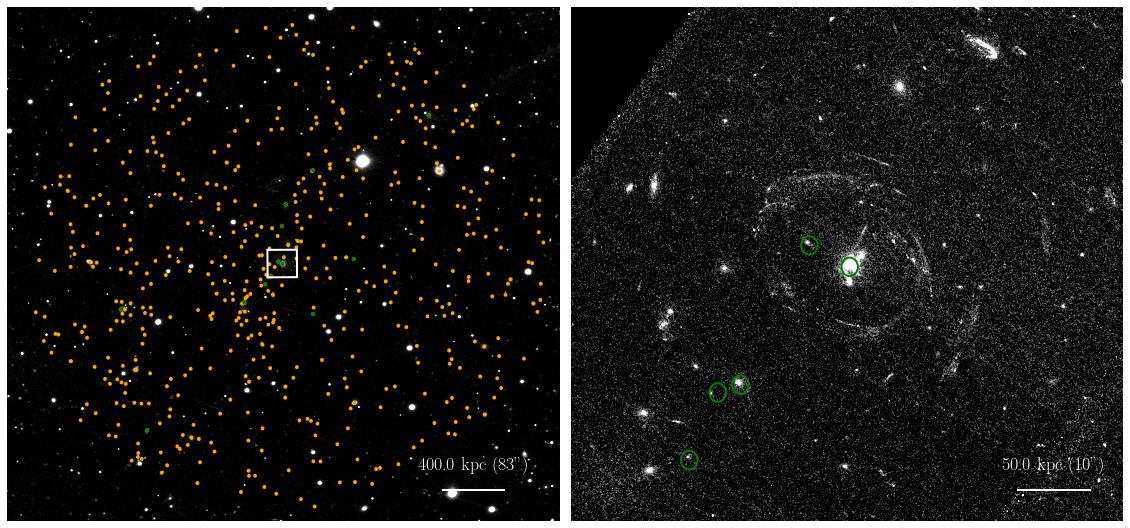

In [63]:
#plot all galaxies in field on top of panstarrs then zoom in on hst
fig = plt.figure(figsize=(20, 10))

#panstarrs
hdu1, hdr1 = phdu, phdr
cmap = cm.Greys_r

clim = [0, 2e3]
zoom = None
            
gs1 = GridSpec(1, 2)
gs1.update(wspace=0.02)

ax1 = fig.add_subplot(gs1[0, 0], projection=WCS(hdr1))
ax1, cb1 = pf.ax_fits_map(hdu1, coords=zoom, cmap=cmap, ax=ax1, vmin=clim[0], 
                    vmax=clim[1], cbar=False)

galaxy_coords = np.stack((sdss1531_field_galaxies.RA, sdss1531_field_galaxies.DEC), axis=1)
pf.overlay(ax1, None, 1, None, None, clusters=True, cont_color='orange', 
            ysc_coords=galaxy_coords, rad = 0.0008)
galaxy_coords = np.stack((sdss1531_field_galaxies_z.RA, sdss1531_field_galaxies_z.DEC), axis=1)
pf.overlay(ax1, None, 1, None, None, clusters=True, cont_color='g', 
            ysc_coords=galaxy_coords, rad = 0.0008, lw=2)

#add hst box

region_string = """
# Region file format: DS9 version 4.1
global color=white dashlist=8 3 width=2 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
box(232.7942938,34.2404172,40",40",0)
"""
patch_list=pf.region_shapes(region_string, phdr)
ax1.add_patch(patch_list[0])
pf.add_scale(ax1, 400 * u.kpc, phdr, cosmo, color='w', ytxt=0.05, xtf=0.9, lw=2, fsize=18)
ax1.axis('off')

#hst

hdu1, hdr1 = f390_hdu, f390_hdr
clim = [0, 0.005]
zoom = [ra+ 6e-4, dec,40 * u.arcsec]

ax2 = fig.add_subplot(gs1[0, 1], projection=WCS(hdr1))
ax2, cb2 = pf.ax_fits_map(hdu1, coords=zoom, cmap=cmap, ax=ax2, vmin=clim[0], 
                    vmax=clim[1], spitzer=True, cbar=False)

xlim, ylim = ax2.get_xlim(), ax2.get_ylim()

galaxy_coords = np.stack((sdss1531_field_galaxies_z.RA, sdss1531_field_galaxies_z.DEC), axis=1)
pf.overlay(ax2, None, 1, None, None, clusters=True, cont_color='g', 
            ysc_coords=galaxy_coords, rad = 0.0008, lw=2)

pf.add_scale(ax2, 50 * u.kpc, hdr1, cosmo, color='w', ytxt=0.05, lw=2, hdr_cdelt='CD2_2', fsize=18)
ax2.axis('off')

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

(-0.5, 2999.5, -0.5, 2999.5)

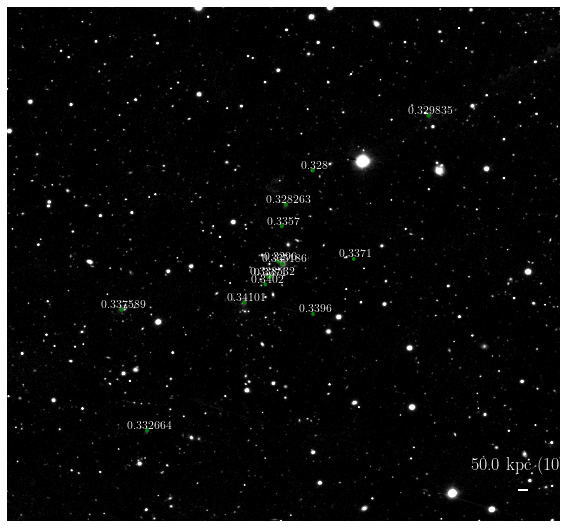

In [70]:
#plot all galaxies with redshifts

fig = plt.figure(figsize=(20, 10))

#panstarrs
hdu1, hdr1 = phdu, phdr
cmap = cm.Greys_r

clim = [0, 2e3]
zoom = None
            
gs1 = GridSpec(1, 2)
gs1.update(wspace=0.02)

ax1 = fig.add_subplot(gs1[0, 0], projection=WCS(hdr1))
ax1, cb1 = pf.ax_fits_map(hdu1, coords=zoom, cmap=cmap, ax=ax1, vmin=clim[0], 
                    vmax=clim[1], cbar=False)

galaxy_coords = np.stack((sdss1531_field_galaxies_z.RA, sdss1531_field_galaxies_z.DEC), axis=1)
pf.overlay(ax1, None, 1, None, None, clusters=True, cont_color='g', 
            ysc_coords=galaxy_coords, rad = 0.0008, lw=2, 
            add_text=sdss1531_field_galaxies_z.Redshift.to_list())


# galaxy_coords = np.stack((sdss1531_field_galaxies_z.RA, sdss1531_field_galaxies_z.DEC), axis=1)
# pf.overlay(ax2, None, 1, None, None, clusters=True, cont_color='g', 
#             ysc_coords=galaxy_coords, rad = 0.0008, lw=2)

pf.add_scale(ax1, 50 * u.kpc, hdr1, cosmo, color='w', ytxt=0.05, lw=2, fsize=18)
ax1.axis('off')

### 3. Histogram of known redshifts

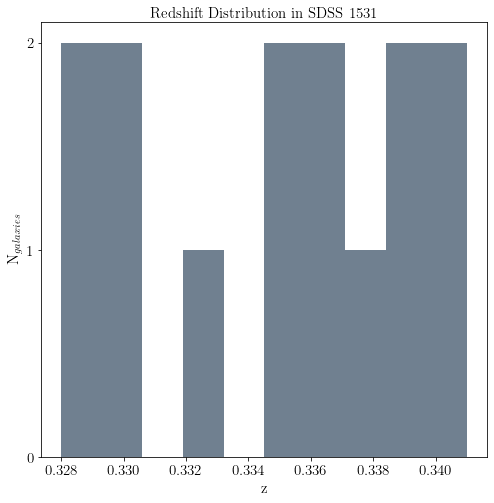

In [55]:
plt.figure(figsize=(8,8))
plt.hist(sdss1531_field_galaxies_z.Redshift, color='slategray')
plt.xlabel('z')
plt.ylabel('N$_{galaxies}$')
plt.title('Redshift Distribution in SDSS 1531')
plt.gca().set_yticks([0,1,2])

plt.savefig(fig_path + 'hst_galaxies_z.pdf') 

### 4 Relative velocity of central galaxies to cluster mean

In [71]:
def relative_velocity(z_galaxy, z_cluster=0.335):
    """
    Calculate the relative velocity of a galaxy at z=z_galaxy
    with respect to a cluster at z=z_cluster. 
    """
    c = const.c.to(u.km/u.s)
    return c * (z_galaxy - z_cluster) / (1 + z_cluster)

In [80]:
z_cluster_mean = np.mean(sdss1531_field_galaxies_z.drop([514]).Redshift)
vlos = relative_velocity(sdss1531_field_galaxies_z.drop([514]).Redshift)

In [87]:
vlos_n = relative_velocity(0.33308579131288074, z_cluster=z_cluster_mean)
vlos_s = relative_velocity(0.33446885559885453, z_cluster=z_cluster_mean)

In [90]:
z_cluster_mean

0.33501484615384614

In [89]:
vlos_s

<Quantity -122.60826237 km / s>

In [88]:
vlos_n

<Quantity -433.19075743 km / s>

In [86]:
(0.335) * const.c.to(u.km/u.s)

<Quantity 100430.47343 km / s>

In [79]:
sdss1531_field_galaxies_z

,No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
169,170,WISEA J153054.64+341803.0,232.72791,34.30070,G,98882.0,0.329835,SPEC,20.4g,4.871,4,0,53,5,2,8,0
311,312,SDSS J153102.80+341432.8,232.76170,34.24245,G,101060.0,0.337100,,23.3g,1.592,1,0,15,1,1,4,0
418,419,WISEA J153107.18+341312.2,232.78008,34.22003,G,101810.0,0.339600,,23.2g,1.397,1,0,27,2,1,4,0
420,421,[BHG2011] J153107.33+341641.6,232.78058,34.27823,G,98332.0,0.328000,,,2.360,1,0,0,1,1,0,0
500,501,WISEA J153110.29+341551.4,232.79283,34.26434,G,98411.0,0.328263,SPEC,20.5g,1.436,1,0,27,3,1,4,0
514,515,WISEA J153110.59+341425.2,232.79416,34.24028,G,100486.0,0.335186,SPEC,19.2g,0.024,15,0,63,7,5,10,0
517,518,WISEA J153110.72+341519.6,232.79458,34.25551,G,100640.0,0.335700,,21.9g,0.907,1,0,27,2,1,4,0
530,531,SDSS J153111.06+341428.3,232.79612,34.24121,G,98812.0,0.329600,,22.2g,0.130,1,0,15,1,2,4,0
567,568,WISEA J153111.91+341406.7,232.79948,34.23519,G,101489.0,0.338532,SPEC,20.9g,0.425,1,0,27,3,1,4,0
576,577,[BHG2011] J153112.13+341405.4,232.80058,34.23485,G,101060.0,0.337100,,,0.478,1,0,0,1,1,0,0


In [77]:
(z_cluster_mean - 0.335) * const.c.to(u.km/u.s)

<Quantity 8.11581011 km / s>

In [75]:
vlos

169   -1159.871195
311     471.583642
418    1032.992739
420   -1571.945473
500   -1512.885236
514      41.768837
517     157.194547
530   -1212.643650
567     793.158773
576     471.583642
588    1167.730923
663    1349.627470
891    -524.580661
967     581.395261
Name: Redshift, dtype: float64

### 5. Gas Stripped From Interactions with other gas-rich galaxies?

In [13]:
(100 * u.kpc)/kpc_per_arcsec

<Quantity 20.977099 arcsec>

(4110.0, 5510.0)

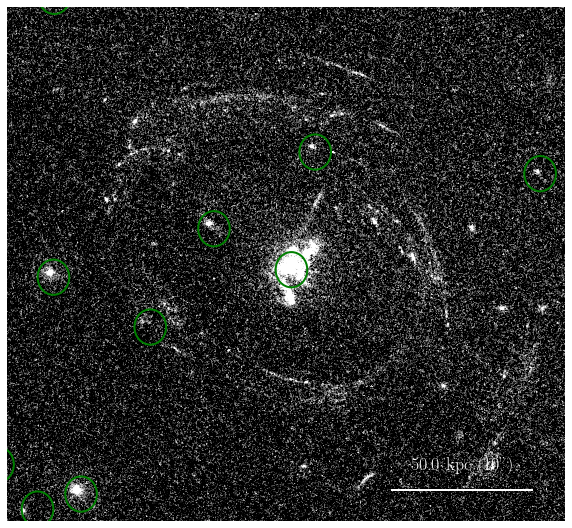

In [22]:
#plot all galaxies in field on top of panstarrs then zoom in on hst
fig = plt.figure(figsize=(10, 10))

#hst
gs1 = GridSpec(1, 1)

hdu1, hdr1 = f390_hdu, f390_hdr
clim = [0, 0.005]
zoom = [ra+ 6e-4, dec,21 * u.arcsec]
cmap= cm.Greys_r

ax2 = fig.add_subplot(gs1[0], projection=WCS(hdr1))
ax2, cb2 = pf.ax_fits_map(hdu1, coords=zoom, cmap=cmap, ax=ax2, vmin=clim[0], 
                    vmax=clim[1], spitzer=True, cbar=False)

xlim, ylim = ax2.get_xlim(), ax2.get_ylim()

galaxy_coords = np.stack((sdss1531_field_galaxies.RA, sdss1531_field_galaxies.DEC), axis=1)
pf.overlay(ax2, None, 1, None, None, clusters=True, cont_color='g', 
            ysc_coords=galaxy_coords, rad = 0.0008, lw=2)

pf.add_scale(ax2, 50 * u.kpc, hdr1, cosmo, color='w', ytxt=0.05, lw=2, hdr_cdelt='CD2_2', fsize=18)
ax2.axis('off')

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

In [28]:
num_nuv_gals = 8
h2_strip =  1e9 * u.solMass#jachym 2019
total_stripped = num_nuv_gals * h2_strip

In [38]:
print("Total gas stripped: {:.2e}".format(total_stripped))

Total gas stripped: 8.00e+09 solMass
